In [71]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [72]:
df=yf.download("RELIANCE.NS",start='2023-12-26',end='2025-12-26',interval='1d')
df.reset_index(inplace=True)


/tmp/ipython-input-4137157674.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download("RELIANCE.NS",start='2023-12-26',end='2025-12-26',interval='1d')
[*********************100%***********************]  1 of 1 completed


In [73]:
df["sma_values1",""]=df["Close"].rolling(window=50).mean()
df["sma_values2",""]=df["Close"].rolling(window=100).mean()

In [74]:
print(df.columns)

MultiIndex([(       'Date',            ''),
            (      'Close', 'RELIANCE.NS'),
            (       'High', 'RELIANCE.NS'),
            (        'Low', 'RELIANCE.NS'),
            (       'Open', 'RELIANCE.NS'),
            (     'Volume', 'RELIANCE.NS'),
            ('sma_values1',            ''),
            ('sma_values2',            '')],
           names=['Price', 'Ticker'])


In [75]:
(df[("Close","RELIANCE.NS")] - df[("sma_values1","")]).abs().describe()

,0
count,447.000000
mean,52.869081
std,40.302904
min,0.151846
25%,17.355747
50%,46.123569
75%,80.875255
max,174.572832


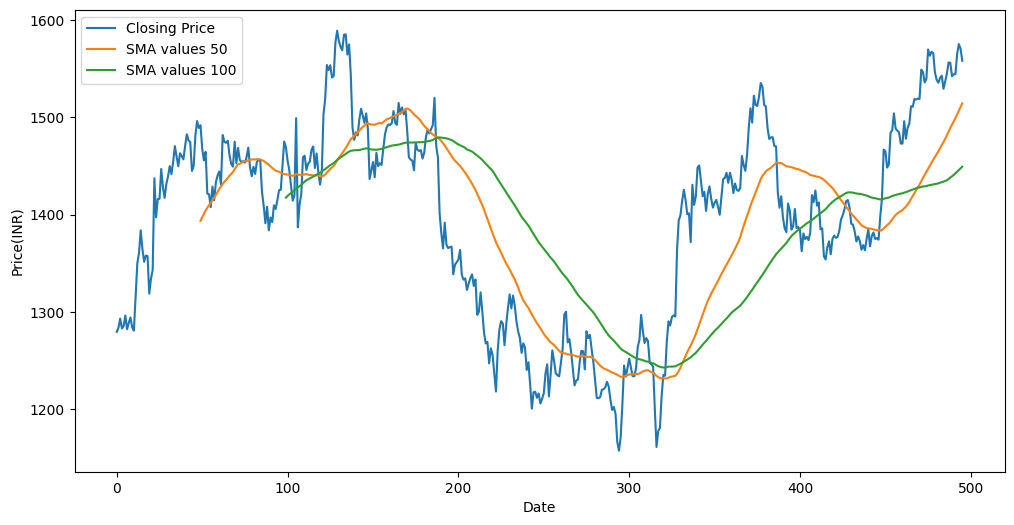

In [76]:
plt.figure(figsize=(12,6))
plt.plot(df[("Close",'RELIANCE.NS')],label="Closing Price")
plt.plot(df[("sma_values1",'')],label="SMA values 50")
plt.plot(df[("sma_values2",'')],label="SMA values 100")
plt.xlabel("Date")
plt.ylabel("Price(INR)")
plt.legend()
plt.show()


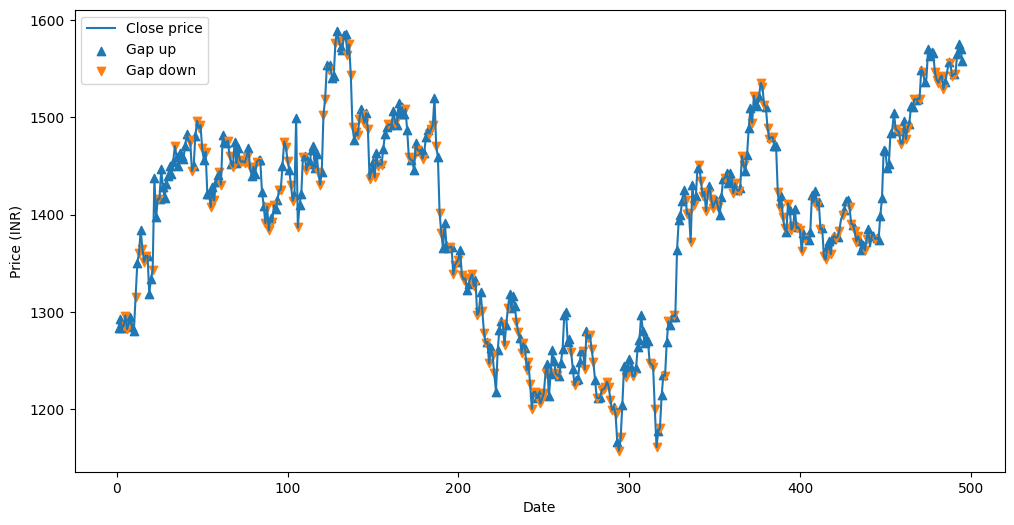

In [77]:
##Q1 part 2
df['Gap up']=(df['Open']>df['Close'].shift(1)).fillna(False).astype(bool)
df['Gap down']=(df['Open']<df['Close'].shift(1)).fillna(False).astype(bool)
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label="Close price")

gap_up_close = df.loc[df["Gap up"], "Close"]
gap_down_close = df.loc[df["Gap down"], "Close"]

plt.scatter(gap_up_close.index, gap_up_close, label="Gap up", marker="^")
plt.scatter(gap_down_close.index, gap_down_close, label="Gap down", marker="v")

plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()



/tmp/ipython-input-2277466539.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df2=yf.download("RELIANCE.NS",interval="5m",period="1d")
[*********************100%***********************]  1 of 1 completed


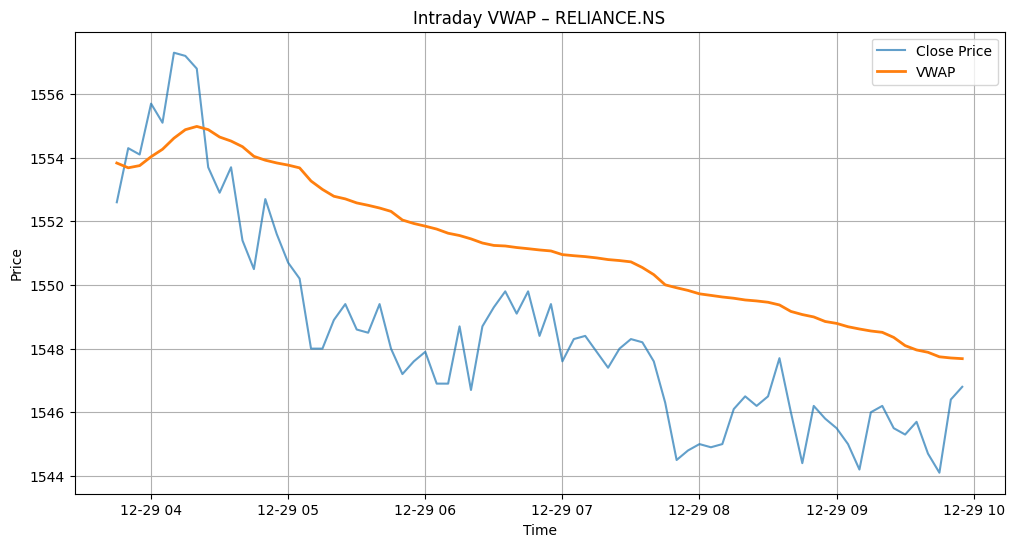

In [78]:
##Q1 part3
df2=yf.download("RELIANCE.NS",interval="5m",period="1d")
df2.columns = df2.columns.get_level_values(0)
df2['Typical_Price']=(df2['High']+df2['Low']+df2['Close'])/3
df2['pv']=df2['Typical_Price']*df2['Volume']
cum_pv=df2.groupby(df2.index.date)['pv'].cumsum()
cum_vol=df2.groupby(df2.index.date)['Volume'].cumsum()
df2['VWAP']=cum_pv/cum_vol
plt.figure(figsize=(12,6))
plt.plot(df2.index, df2['Close'], label='Close Price', alpha=0.7)
plt.plot(df2.index, df2['VWAP'], label='VWAP', linewidth=2)

plt.title("Intraday VWAP – RELIANCE.NS")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipython-input-152532701.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df3=yf.download("TCS.NS",start='2025-06-01',end='2025-12-24',interval='1h')
[*********************100%***********************]  1 of 1 completed


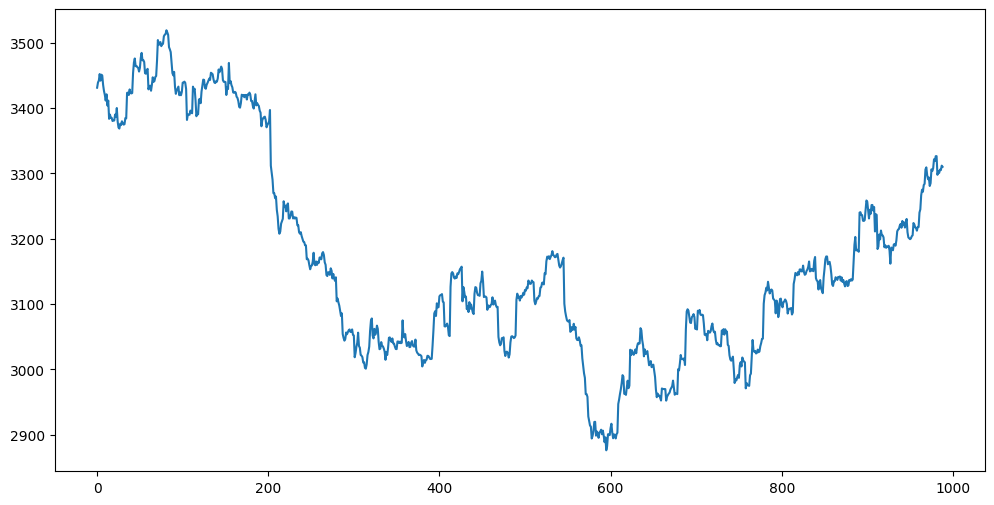

In [79]:
##Q2
df3=yf.download("TCS.NS",start='2025-06-01',end='2025-12-24',interval='1h')
df3.reset_index(inplace=True)
plt.figure(figsize=(12,6))
plt.plot(df3['Close'])
plt.show()


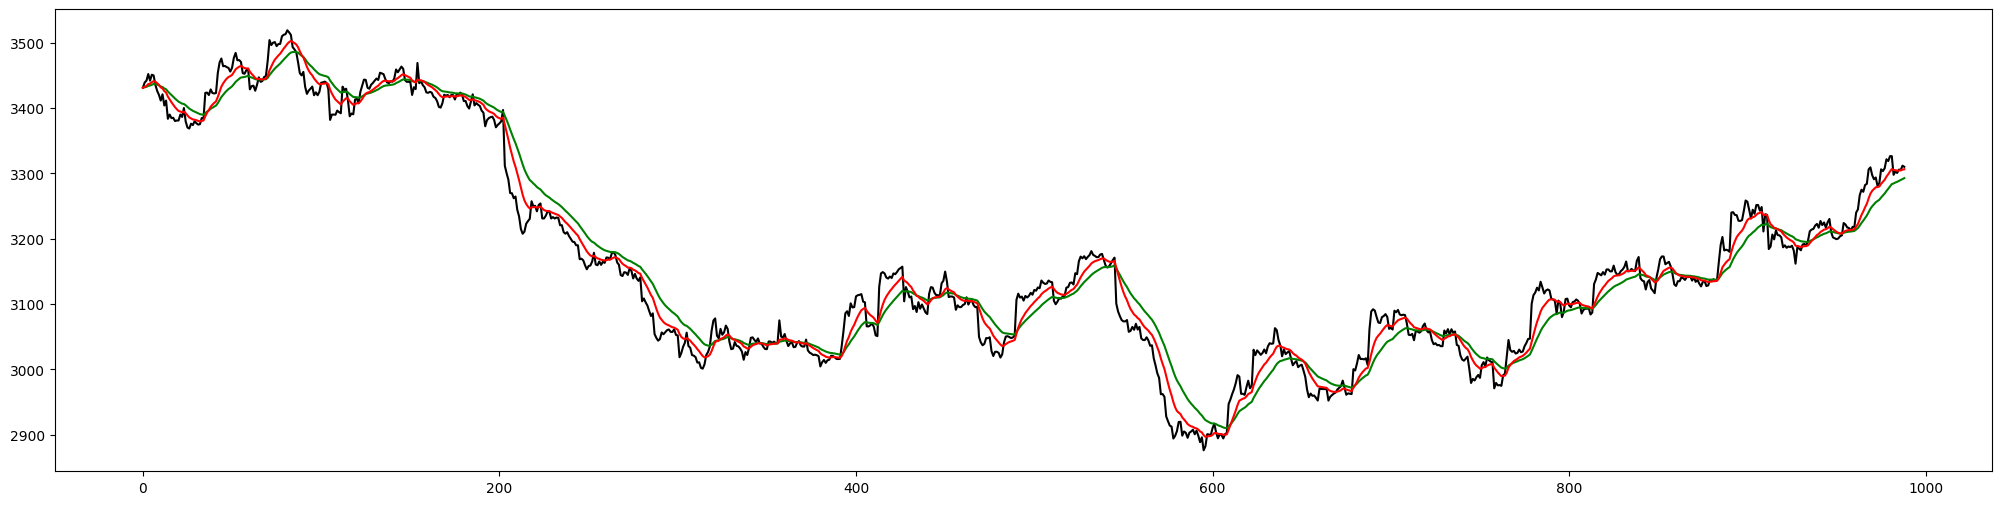

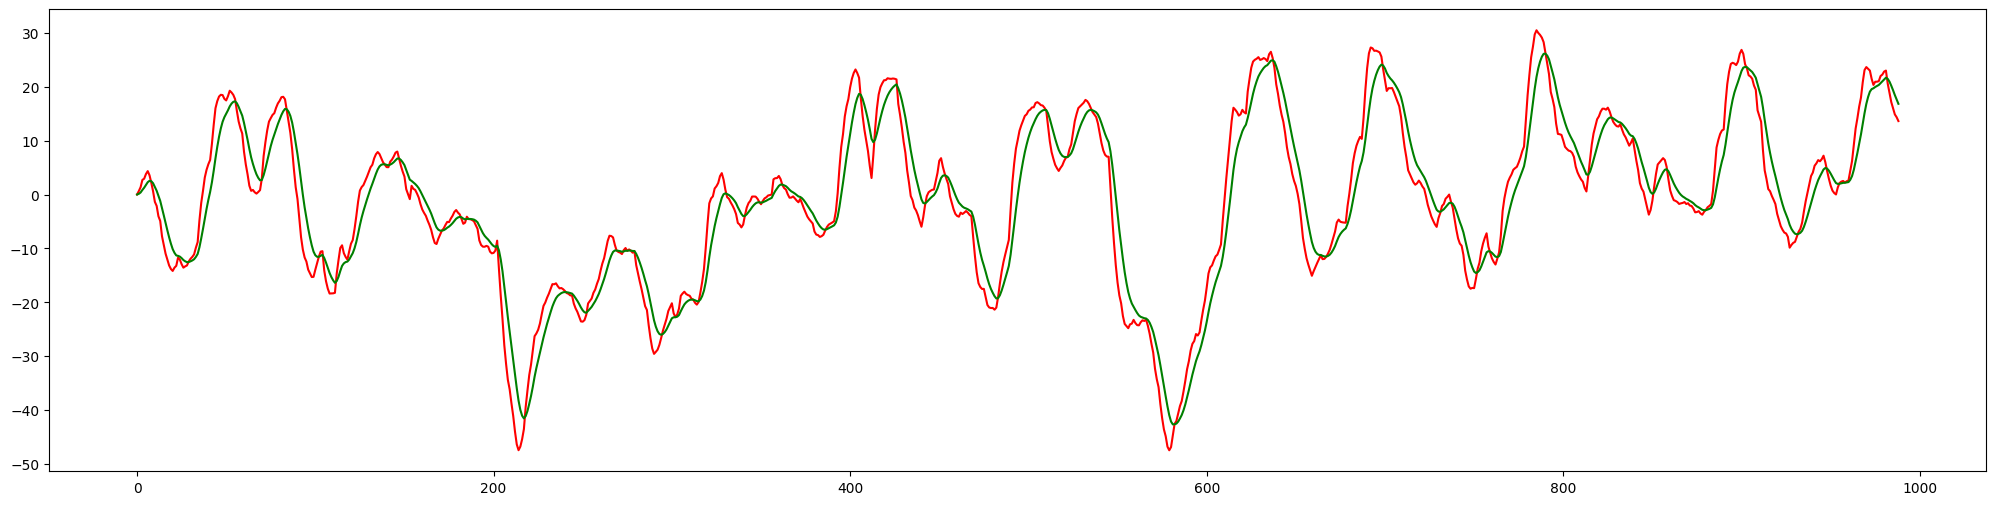

In [80]:
def macd(df3,short_period,long_period,p):
 df3['long_ema']=df3['Close'].ewm(span=long_period,adjust=False).mean()
 df3['short_ema']=df3['Close'].ewm(span=short_period,adjust=False).mean()
 df3['MACD']=df3['short_ema']-df3['long_ema']
 df3['signal_line']=df3['MACD'].ewm(span=p,adjust=False).mean()
 df3['macd_signal']=df3['signal_line']-df3['MACD']
 return df3

df3=macd(df3,12,26,9)
plt.figure(figsize=(25,6))
plt.plot(df3['Close'],color='black')
plt.plot(df3['long_ema'],color='green')
plt.plot(df3['short_ema'],color='red')
plt.show()

plt.figure(figsize=(25,6))
plt.plot(df3['MACD'],color='red')
plt.plot(df3['signal_line'],color='green')
plt.show()

In [81]:
print(len(df3))

989


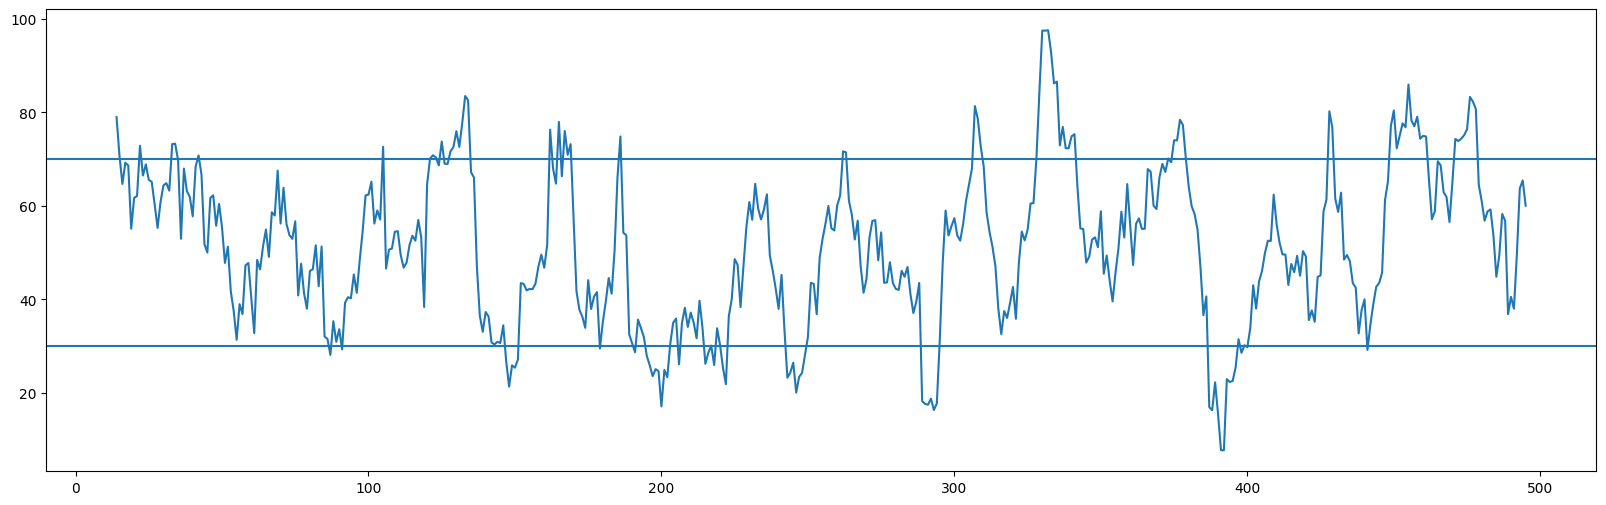

In [82]:
def rsi(df,period):
  df['diff']=df['Close'].diff()
  df['Gain']=(np.where(df['diff']<0,0,df['diff']))
  df['Loss']=(np.where(df['diff']>0,0,-df['diff']))
  df['avg_gain']=df['Gain'].rolling(period).mean()
  df['avg_loss']=df['Loss'].rolling(period).mean()
  df['avg_loss'] = df['avg_loss'].replace(0, np.nan)
  df['RS']=df['avg_gain']/df['avg_loss']
  df['RSI']=100 - (100/(1+df['RS']))
  return df

df3 = rsi(df,14)
plt.figure(figsize=(20,6))
plt.plot(df3['RSI'])
plt.axhline(y = 70,)
plt.axhline(y = 30)
plt.show()

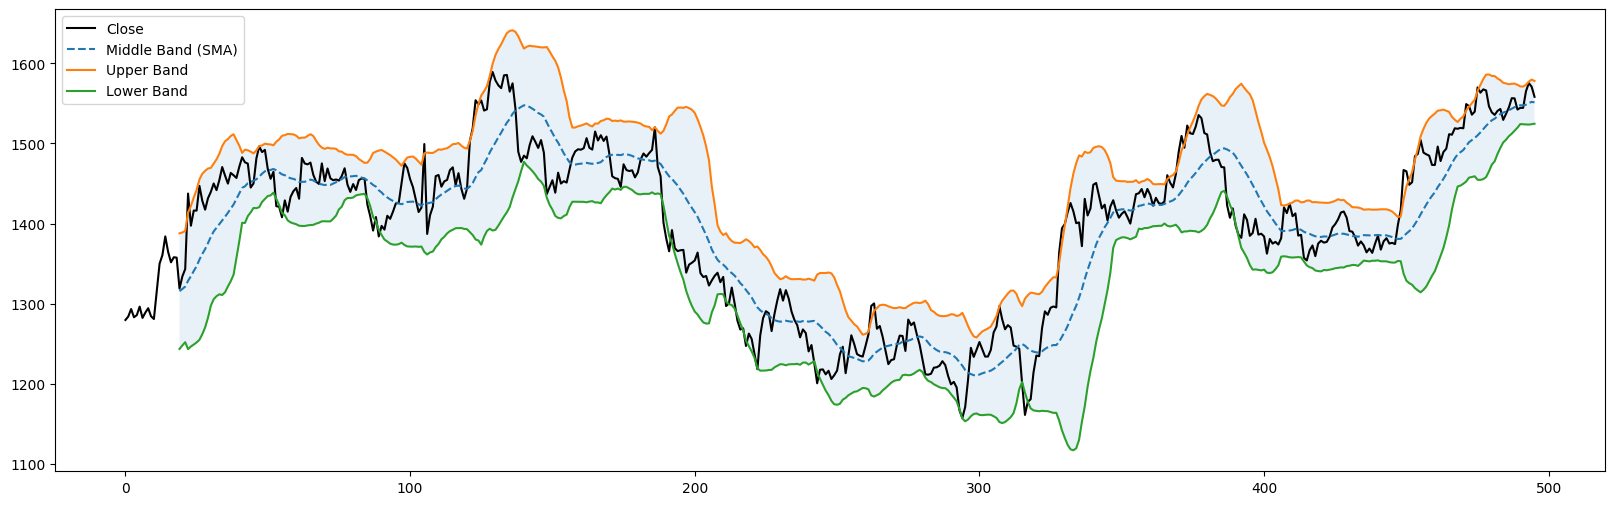

In [87]:
def bollinger_bands(df,window,num_std):
 df=df.copy()
 df['BB_Middle']=df['Close'].rolling(window).mean()
 df['BB_std']=df['Close'].rolling(window).std()
 df['BB_upper']=df['BB_Middle']+df['BB_std']*num_std
 df['BB_lower']=df['BB_Middle']-df['BB_std']*num_std
 return df

df3=bollinger_bands(df3,20,2)
plt.figure(figsize=(20,6))
plt.plot(df3['Close'], label='Close', color='black')
plt.plot(df3['BB_Middle'], label='Middle Band (SMA)', linestyle='--')
plt.plot(df3['BB_upper'], label='Upper Band')
plt.plot(df3['BB_lower'], label='Lower Band')
plt.fill_between(df3.index, df3['BB_lower'], df3['BB_upper'], alpha=0.1)

plt.legend()
plt.show()



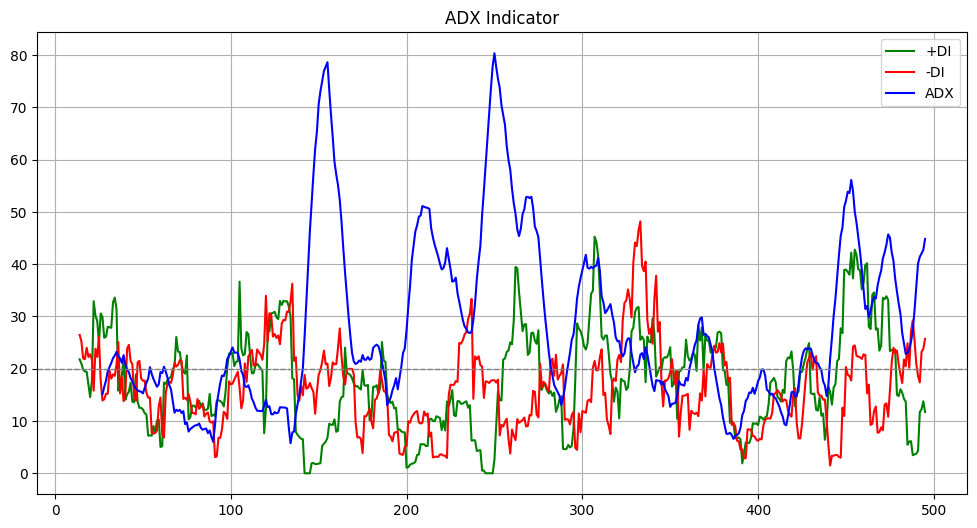

In [109]:
def adx(df, period=14):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]

    high_col = [c for c in df.columns if 'High' in c][0]
    low_col = [c for c in df.columns if 'Low' in c][0]
    close_col = [c for c in df.columns if 'Close' in c][0]

    high = df[high_col]
    low = df[low_col]
    close = df[close_col]

    high_diff = high.diff()
    low_diff = low.diff()

    plus_dm = pd.Series(np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0), index=df.index)
    minus_dm = pd.Series(np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0), index=df.index)

    tr = pd.Series(np.maximum(
        high - low,
        np.maximum(abs(high - close.shift()), abs(low - close.shift()))
    ), index=df.index)

    atr = tr.rolling(period).mean()

    plus_di = 100 * (plus_dm.rolling(period).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(period).mean() / atr)

    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
    adx_val = dx.rolling(period).mean()

    df['+DI'] = plus_di
    df['-DI'] = minus_di
    df['ADX'] = adx_val

    return df
df = adx(df, period=14)

plt.figure(figsize=(12,6))
plt.plot(df['+DI'], label='+DI', color='green')
plt.plot(df['-DI'], label='-DI', color='red')
plt.plot(df['ADX'], label='ADX', color='blue')
plt.axhline(20, linestyle='--', linewidth=1, color='gray')
plt.title('ADX Indicator')
plt.legend()
plt.grid(True)
plt.show()





In [110]:
def stochastic_oscillator(df,k_period,d_period):
  df=df.cpoy()
  low_min = df['Low'].rolling(k_period).min()
  high_max = df['High'].rolling(k_period).max()

  df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
  df['%D'] = df['%K'].rolling(d_period).mean()
  return df

In [111]:
def atr(df, period=14):
    df = df.copy()
    tr = np.maximum(df['High'] - df['Low'],
         np.maximum(abs(df['High'] - df['Close'].shift()),
                    abs(df['Low'] - df['Close'].shift())))
    df['ATR'] = tr.rolling(period).mean()
    return df


In [182]:
##Q2 part 2
import pandas as pd

if isinstance(df3.columns, pd.MultiIndex):
    df3.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df3.columns]

close_col = [col for col in df3.columns if col.lower().startswith('close')][0]

def bb_signal(df, close_col, window=20, num_std=2):
    df = df.copy()
    df['BB_Middle'] = df[close_col].rolling(window).mean()
    df['BB_std'] = df[close_col].rolling(window).std()
    df['BB_Upper'] = df['BB_Middle'] + df['BB_std'] * num_std
    df['BB_Lower'] = df['BB_Middle'] - df['BB_std'] * num_std

    signal = pd.Series('Hold', index=df.index)
    signal[df[close_col] < df['BB_Lower']] = 'Buy'
    signal[df[close_col] > df['BB_Upper']] = 'Sell'

    return signal

bb_signals = bb_signal(df3, close_col)
print(bb_signals.tail())


491    Hold
492    Hold
493    Hold
494    Hold
495    Hold
dtype: object


In [190]:
if isinstance(df3.columns, pd.MultiIndex):
    df3.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df3.columns]
def rsi_signal(df):
    signal = pd.Series('Hold', index=df.index)
    signal[df['RSI_'] < 30] = 'Buy'
    signal[df['RSI_'] > 70] = 'Sell'
    return signal

# Generate RSI signals
rsi_signals = rsi_signal(df3)
print(rsi_signals.tail())






491    Hold
492    Hold
493    Hold
494    Hold
495    Hold
dtype: object


In [192]:
def macd_signal(df, close_col, fast=12, slow=26, signal_period=9):
    df = df.copy()
    ema_fast = df[close_col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[close_col].ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

    signal = pd.Series('Hold', index=df.index)
    signal[macd_line > signal_line] = 'Buy'
    signal[macd_line < signal_line] = 'Sell'

    macd_signals = signal
    print("MACD Signals:\n", macd_signals.tail())
    return macd_signals

# Example usage:
close_col = [col for col in df3.columns if col.lower().startswith('close')][0]
macd_signals = macd_signal(df3, close_col)



MACD Signals:
 491    Sell
492    Sell
493    Sell
494    Sell
495    Sell
dtype: object


In [193]:
def adx_signal(df, high_col, low_col, close_col, period=14):
    df = df.copy()
    plus_dm = df[high_col].diff()
    minus_dm = df[low_col].diff().mul(-1)
    plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
    minus_dm = minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)

    tr1 = df[high_col] - df[low_col]
    tr2 = (df[high_col] - df[close_col].shift()).abs()
    tr3 = (df[low_col] - df[close_col].shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(period).mean()

    plus_di = 100 * (plus_dm.rolling(period).sum() / atr)
    minus_di = 100 * (minus_dm.rolling(period).sum() / atr)

    signal = pd.Series('Hold', index=df.index)
    signal[plus_di > minus_di] = 'Buy'
    signal[plus_di < minus_di] = 'Sell'

    adx_signals = signal
    print("ADX Signals:\n", adx_signals.tail())
    return adx_signals

# Example usage:
high_col = [col for col in df3.columns if col.lower().startswith('high')][0]
low_col = [col for col in df3.columns if col.lower().startswith('low')][0]
close_col = [col for col in df3.columns if col.lower().startswith('close')][0]

adx_signals = adx_signal(df3, high_col, low_col, close_col)



ADX Signals:
 491    Sell
492    Sell
493    Sell
494    Sell
495     Buy
dtype: object


In [195]:
def stochastic_signal(df, high_col, low_col, close_col, k_period=14, d_period=3):
    df = df.copy()
    low_min = df[low_col].rolling(k_period).min()
    high_max = df[high_col].rolling(k_period).max()
    k = 100 * ((df[close_col] - low_min) / (high_max - low_min))
    d = k.rolling(d_period).mean()

    signal = pd.Series('Hold', index=df.index)
    signal[k < 20] = 'Buy'
    signal[k > 80] = 'Sell'

    stoch_signals = signal
    print("Stochastic Signals:\n", stoch_signals.tail())
    return stoch_signals

high_col = [col for col in df3.columns if col.lower().startswith('high')][0]
low_col = [col for col in df3.columns if col.lower().startswith('low')][0]
close_col = [col for col in df3.columns if col.lower().startswith('close')][0]

stoch_signals = stochastic_signal(df3, high_col, low_col, close_col)



Stochastic Signals:
 491    Hold
492    Sell
493    Sell
494    Sell
495    Hold
dtype: object


In [197]:
def calculate_atr_signal(df, high_col, low_col, close_col, period=14, rolling_period=20):
    df = df.copy()

    tr1 = df[high_col] - df[low_col]
    tr2 = (df[high_col] - df[close_col].shift()).abs()
    tr3 = (df[low_col] - df[close_col].shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    df['ATR'] = tr.rolling(period).mean()
    rolling_avg = df['ATR'].rolling(rolling_period).mean()

    signal = pd.Series('Hold', index=df.index)
    signal[df['ATR'] > rolling_avg] = 'Buy'
    signal[df['ATR'] < rolling_avg] = 'Sell'

    atr_signals = signal
    print("ATR Signals:\n", atr_signals.tail())
    return atr_signals

# Example usage:
high_col = [col for col in df3.columns if col.lower().startswith('high')][0]
low_col = [col for col in df3.columns if col.lower().startswith('low')][0]
close_col = [col for col in df3.columns if col.lower().startswith('close')][0]

atr_signals = calculate_atr_signal(df3, high_col, low_col, close_col)


ATR Signals:
 491    Sell
492    Sell
493    Sell
494    Sell
495    Sell
dtype: object


In [176]:
print(df.columns.tolist())

['Date_', 'Close_RELIANCE.NS', 'High_RELIANCE.NS', 'Low_RELIANCE.NS', 'Open_RELIANCE.NS', 'Volume_RELIANCE.NS', 'sma_values1_', 'sma_values2_', 'Gap up_', 'Gap down_', 'diff_', 'Gain_', 'Loss_', 'avg_gain_', 'avg_loss_', 'RS_', 'RSI_', '+DI', '-DI', 'ADX']
